In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models.common_sql import create_db_connection, select_table


In [2]:
connection = create_db_connection('postgres', 'marshineer', 'localhost', '5432', 'password')
shots_df = select_table(connection, 'shots')
display(shots_df.columns.tolist())


['game_id',
 'shot_id',
 'shooter_id',
 'shot_type',
 'shot_result',
 'period',
 'period_time',
 'home_team_id',
 'away_team_id',
 'home_score',
 'away_score',
 'x_coord',
 'y_coord',
 'net_distance',
 'net_angle',
 'rebound_shot',
 'last_event_type',
 'time_since_last',
 'last_x_coord',
 'last_y_coord',
 'delta_y',
 'angle_change',
 'play_ends',
 'puck_frozen',
 'goal',
 'missed',
 'blocked',
 'empty_net',
 'shooter_home',
 'shooter_hand',
 'off_wing_shot',
 'players_home',
 'players_away']

## Data Cleaning

In [3]:
# Remove rows where the shift data contained errors
shift_error_rows = shots_df[shots_df.players_home.apply(lambda x: len(x) < 36) & shots_df.players_away.apply(lambda x: len(x) < 36) ]
print(f'Number of shift error entries = {len(shift_error_rows)}')
# shots_df = shots_df[shots_df.players_home.apply(lambda x: len(x) > 35) & shots_df.players_away.apply(lambda x: len(x) > 35) ]

# Remove rows with nan/null shot distance
print(f'Number of shots with no distance info = {len(shots_df[shots_df.net_distance.isna()])}')
shots_df.dropna(subset='net_distance', inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove rows with nan/null shot angle
print(f'Number of shots with no angle info = {len(shots_df[shots_df.net_angle.isna()])}')
shots_df.dropna(subset='net_angle', inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove the empty net goals
print(f'Number of goals on empty nets = {len(shots_df[shots_df.empty_net == True])} '
      f'({100 * len(shots_df[shots_df.empty_net == True]) / len(shots_df[shots_df.shot_result == "GOAL"]):4.2f}% of all goals)')
shots_df.drop(shots_df[shots_df.empty_net == True].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove all shots that come from outside the blueline
long_mask = (((shots_df.period % 2 == 1) ^ (shots_df.shooter_home == True)) & (shots_df.x_coord < 25)) | \
    (~((shots_df.period % 2 == 1) ^ (shots_df.shooter_home == True)) & (shots_df.x_coord > -25))
print(f'Number of shots from outside the blueline = {sum(long_mask)} ({100 * sum(long_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[long_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove all shots from directly behind the net
# Note: keeping some shots from behind the goal line, as bank shots often invovle skill and/or intelligence
behind_net_mask = (shots_df.net_angle > 120) | (shots_df.net_angle < -120)
print(f'Number of shots from behind the net = {sum(behind_net_mask)} ({100 * sum(behind_net_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[behind_net_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)


Number of shift error entries = 342
Number of shots with no distance info = 45
Number of shots with no angle info = 0
Number of goals on empty nets = 3880 (4.64% of all goals)
Number of shots from outside the blueline = 48009 (2.85% of all shots)
Number of shots from behind the net = 450 (0.03% of all shots)


In [4]:
# Create subsets of the shots
shots_wo_blocks = shots_df[shots_df.shot_result != 'BLOCK']
goal_mask = shots_wo_blocks.shot_result == 'GOAL'


# Shot Angle and Distance

The relatively high probablility of a goal on a shot from greater than a 90 degree angle (i.e. from behind the goal line) is due to the number of misses from that angle, and that players are more selective when choosing to shoot from behind the net or at a low angle.

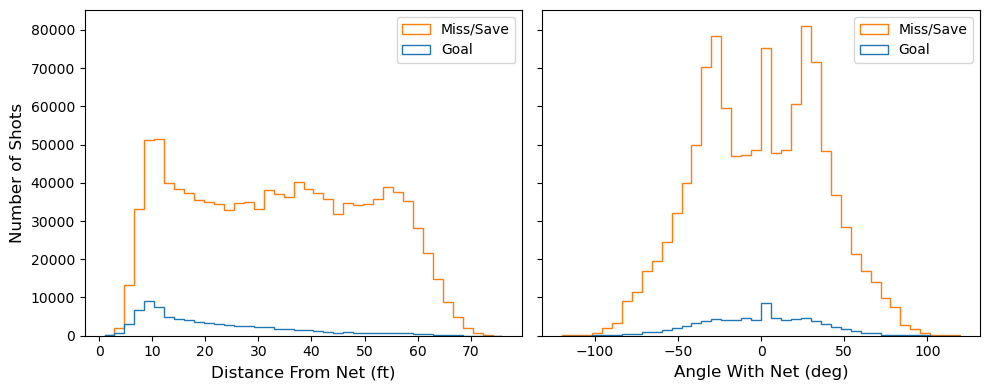

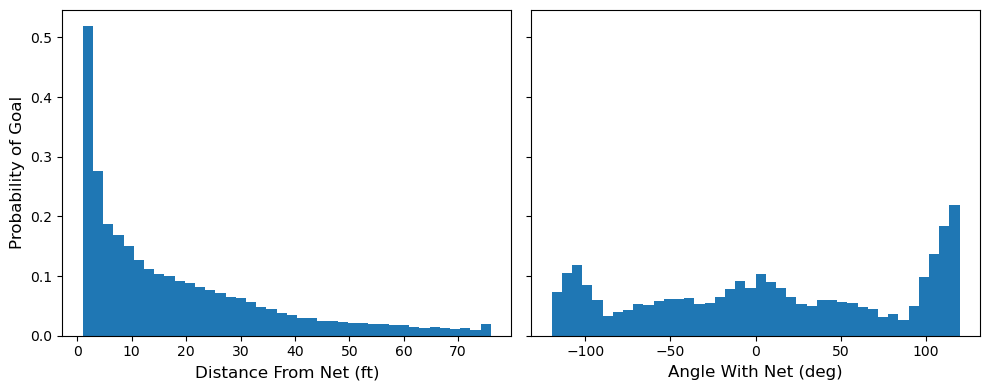

In [5]:
# Plot distributions for shot distance and angle
shot_cols = ['net_distance', 'net_angle']
x_lbls = ['Distance From Net (ft)', 'Angle With Net (deg)']

fig1, ax1 = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig2, ax2 = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, col in enumerate(shot_cols):
    # Get shot counts for goals and non-goals (misses, saves)
    shot_plt = shots_wo_blocks[['shot_result', f'{col}']]
    goal_shots = shot_plt[f'{col}'].loc[goal_mask]
    non_goal_shots = shot_plt[f'{col}'].loc[~goal_mask]
    _, bins = np.histogram(shot_plt[f'{col}'], bins=40)
    goal_cnts, _ = np.histogram(goal_shots, bins)
    non_goal_cnts, _ = np.histogram(non_goal_shots, bins)
    # print(goal_cnts)
    # print(non_goal_cnts)
    
    # Calculate the probability a shot from each distance/angle will result in a goal
    p_goal = goal_cnts / (non_goal_cnts + goal_cnts)
    width = bins[1] - bins[0]
    center = (bins[:-1] + bins[1:]) / 2

    # Plot the shot distance distribution
    # ax1[i].hist([goal_shots, non_goal_shots], bins, histtype='bar', stacked=True, label=['Goal', 'Miss/Save'])
    ax1[i].hist([goal_shots, non_goal_shots], bins, histtype='step', stacked=False, label=['Goal', 'Miss/Save'])
    ax1[i].set_xlabel(x_lbls[i], fontsize=12)
    ax1[i].legend()
    # ax1[i].set_ylim([0, 1000])
    ax2[i].bar(center, p_goal, align='center', width=width)
    ax2[i].set_xlabel(x_lbls[i], fontsize=12)
ax1[0].set_ylabel('Number of Shots', fontsize=12)
ax2[0].set_ylabel('Probability of Goal', fontsize=12)
fig1.tight_layout()
fig2.tight_layout()
plt.show()


Total number of shots = 1214273
Total number of goals = 79331
Average shooting percentage = 6.53


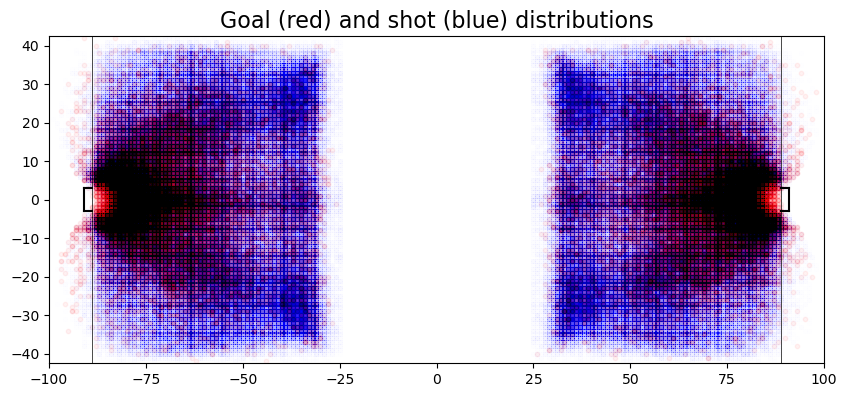

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4.25))
# Rink limits
ax.set_xlim([-100, 100])
ax.set_ylim([-42.5, 42.5])
# Goal lines
ax.plot([89, 89], [-42.5, 42.5], 'k', lw=0.5)
ax.plot([-89, -89], [-42.5, 42.5], 'k', lw=0.5)
# Nets
ax.plot([-89, -91], [-3, -3], 'k')
ax.plot([-89, -91], [3, 3], 'k')
ax.plot([-91, -91], [-3, 3], 'k')
ax.plot([89, 91], [-3, -3], 'k')
ax.plot([89, 91], [3, 3], 'k')
ax.plot([91, 91], [-3, 3], 'k')

# Masks
goals_x = shots_wo_blocks['x_coord'].loc[goal_mask]
goals_y = shots_wo_blocks['y_coord'].loc[goal_mask]
shots_x = shots_wo_blocks['x_coord'].loc[~goal_mask]
shots_y = shots_wo_blocks['y_coord'].loc[~goal_mask]
ax.scatter(goals_x, goals_y, c='r', s=10, alpha=0.05, label='Goal')
ax.scatter(shots_x, shots_y, c='b', s=10, alpha=0.002, label='Shot')
# ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.025), fontsize=12)
ax.set_title('Goal (red) and shot (blue) distributions', fontsize=16)

# Print statements
n_goals = len(shots_wo_blocks.loc[goal_mask])
n_shots = len(shots_wo_blocks)
print(f'Total number of shots = {n_shots}')
print(f'Total number of goals = {n_goals}')
print(f'Average shooting percentage = {100 * n_goals / n_shots:4.2f}')
# print(min(shots_df.x_coord + 100))
# print(max(shots_df.x_coord) + 100)
# print(int(min(shots_df.y_coord + 42.5)))
# print(int(max(shots_df.y_coord) + 42.5))


In [7]:
# Convert shots to list
shot_list = shots_df.to_dict('records')
# shot_list = shots_df.loc[~goal_mask].to_dict('records')
# goal_list = shots_df.loc[goal_mask].to_dict('records')


In [8]:
# Heat maps of shots and goals
res = 1
goal_map = np.ones((85 // res, 200 // res))
shot_map = np.ones((85 // res, 200 // res))
# goal_map = np.ones((17, 40))
# shot_map = np.ones((17, 40))
for shot in shot_list:
    # x = int(shot['x_coord'] + 100)
    # y = int(shot['y_coord'] + 42.5)
    x = int(shot['x_coord'] + 100) // res
    y = int(shot['y_coord'] + 42.5) // res
    if shot['shot_result'] == 'GOAL':
        goal_map[y, x] += 1
    else:
        shot_map[y, x] += 1


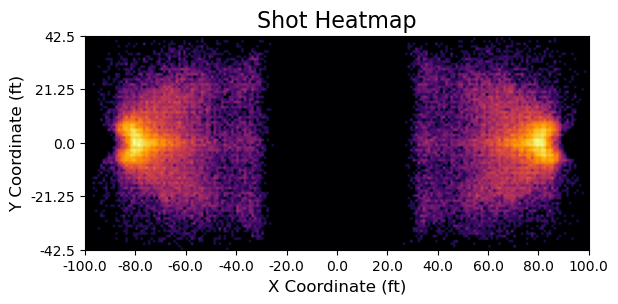

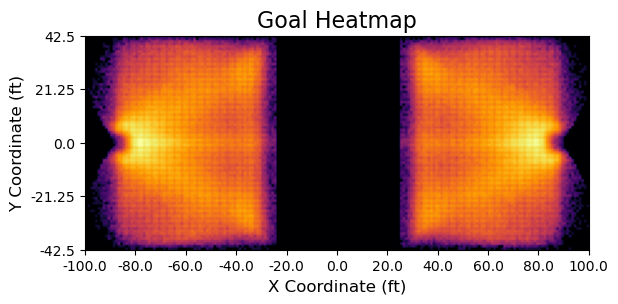

In [9]:
# Plot heatmaps of the shot and goal distributions
x_ticks_lbls = np.linspace(-100, 100, 11)
x_ticks = np.arange(0, goal_map.shape[1] + 1, goal_map.shape[1] / 10) - 0.5
y_ticks_lbls = np.linspace(-42.5, 42.5, 5)
y_ticks = np.arange(0, goal_map.shape[0] + 1, goal_map.shape[0] / 4) - 0.5

fig, ax = plt.subplots(1, 1, figsize=(6.5, 3))
# print(np.sum(shot_map) + np.sum(goal_map))
# print((np.argwhere(shot_map == 0).shape))
# print(85 * 200)
# ax.imshow(goal_map - np.mean(goal_map), cmap='bwr')
ax.imshow(np.log(goal_map), cmap='inferno', aspect='equal', origin='lower')
ax.set_xlabel('X Coordinate (ft)', fontsize=12)
ax.set_ylabel('Y Coordinate (ft)', fontsize=12)
ax.set_title('Shot Heatmap', fontsize=16)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks_lbls)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks_lbls)

fig, ax = plt.subplots(1, 1, figsize=(6.5, 3))
# ax.imshow(goal_map - np.mean(goal_map), cmap='bwr')
ax.imshow(np.log(shot_map), cmap='inferno', aspect='equal', origin='lower')
ax.set_xlabel('X Coordinate (ft)', fontsize=12)
ax.set_ylabel('Y Coordinate (ft)', fontsize=12)
ax.set_title('Goal Heatmap', fontsize=16)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks_lbls)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks_lbls);
